In [1]:
#default_exp schedulers

In [2]:
%load_ext autoreload
%autoreload 2

from nbdev.export import *
import warnings

warnings.filterwarnings("ignore")

In [3]:
# export
import math

from fvcore.common import registry
from omegaconf import DictConfig
from torch.optim.lr_scheduler import *
from torch.optim.lr_scheduler import _LRScheduler
from torch.optim.optimizer import Optimizer

from src import _logger

In [5]:
# for test
import matplotlib.pyplot as plt
import torchvision
from omegaconf import OmegaConf

from src.optimizers import OPTIM_REGISTERY

### Create Lr_Scheduler Registery -

In [9]:
# export
SCHEDULER_REGISTERY = registry.Registry("Schedulers")

In [10]:
# export
# register all the default LRSchedulers
SCHEDULER_REGISTERY.register(CosineAnnealingLR)
SCHEDULER_REGISTERY.register(CosineAnnealingWarmRestarts)
SCHEDULER_REGISTERY.register(ReduceLROnPlateau)
SCHEDULER_REGISTERY.register(MultiplicativeLR)
SCHEDULER_REGISTERY.register(MultiStepLR)
SCHEDULER_REGISTERY.register(StepLR)
SCHEDULER_REGISTERY.register(ExponentialLR)
SCHEDULER_REGISTERY.register(CyclicLR)
SCHEDULER_REGISTERY.register(OneCycleLR)

### FlatCosScheduler
> For `Ranger`

In [11]:
# export
@SCHEDULER_REGISTERY.register()
class FlatCosScheduler(_LRScheduler):
    "Fit `epochs` at flat `lr` before a `cosine annealing` from `pct_start`."

    def __init__(
        self, optimizer, epochs, steps_per_epoch, pct_start, eta_min=0, last_epoch=-1,
    ):

        self.max_iters = epochs * steps_per_epoch
        self.flat_range = int(self.max_iters * pct_start)
        self.T_max = self.max_iters - self.flat_range
        self.eta_min = eta_min
        super(FlatCosScheduler, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        if self.last_epoch < self.flat_range:
            return [base_lr for base_lr in self.base_lrs]
        else:
            cr_epoch = self.last_epoch - self.flat_range
            lrs = [
                self.eta_min
                + (base_lr - self.eta_min)
                * (1 + math.cos(math.pi * (cr_epoch / self.T_max)))
                / 2
                for base_lr in self.base_lrs
            ]
            return lrs

Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers


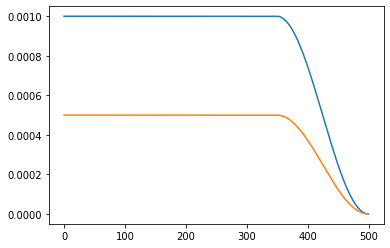

In [12]:
optimizer = "Ranger"
scheduler = "FlatCosScheduler"

num_epochs  = 10
num_batches = 50

optimizer_params = dict(weight_decay=1e-03, betas=(0.95, 0.999), eps=1e-5)
scheduler_params = dict(pct_start=0.7, epochs=num_epochs, steps_per_epoch=num_batches)

model = torchvision.models.resnet18(pretrained=False)
params = [
    dict(params=list(model.parameters())[:-2], lr=1e-03),
    dict(params=list(model.parameters())[-2:], lr=5e-04),
]

optimizer = OPTIM_REGISTERY.get(optimizer)(params=params, **optimizer_params)
scheduler = SCHEDULER_REGISTERY.get(scheduler)(optimizer=optimizer, **scheduler_params)

lr1 = []
lr2 = []

for epoch in range(num_epochs):
    for batch in range(num_batches):
        # called after batch
        scheduler.step()
        lrs = scheduler.get_lr()
        lr1.append(lrs[0])
        lr2.append(lrs[1])
        
plt.plot(lr1)
plt.plot(lr2);

### Constant Warmup Schedule -
> from: https://huggingface.co/transformers/_modules/transformers/optimization.html

In [13]:
# export
@SCHEDULER_REGISTERY.register()
def ConstantWarmup(optimizer: Optimizer, num_warmup_steps: int, last_epoch: int = -1):
    """
    Create a schedule with a constant learning rate preceded by a warmup period during which the learning rate
    increases linearly between 0 and the initial lr set in the optimizer.

    Args:
        optimizer (:class:`~torch.optim.Optimizer`):
            The optimizer for which to schedule the learning rate.
        num_warmup_steps (:obj:`int`):
            The number of steps for the warmup phase.
        last_epoch (:obj:`int`, `optional`, defaults to -1):
            The index of the last epoch when resuming training.
    Return:
        :obj:`torch.optim.lr_scheduler.LambdaLR` with the appropriate schedule.
    """

    def lr_lambda(current_step: int):
        if current_step < num_warmup_steps:
            return float(current_step) / float(max(1.0, num_warmup_steps))
        return 1.0

    return LambdaLR(optimizer, lr_lambda, last_epoch=last_epoch)

Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers


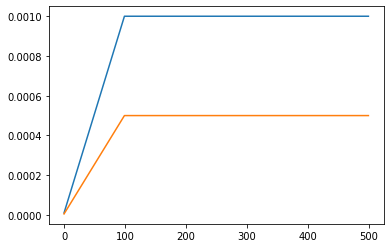

In [14]:
optimizer = "Ranger"
scheduler = "ConstantWarmup"

num_epochs = 10
num_batches = 50

optimizer_params = dict(weight_decay=1e-03, betas=(0.95, 0.999), eps=1e-5)
model = torchvision.models.resnet18(pretrained=False)

optimizer = OPTIM_REGISTERY.get(optimizer)(params=params, **optimizer_params)

scheduler_params = dict(num_warmup_steps=100)
scheduler = SCHEDULER_REGISTERY.get(scheduler)(optimizer=optimizer, **scheduler_params)

lr1 = []
lr2 = []

for epoch in range(num_epochs):
    for batch in range(num_batches):
        scheduler.step()
        lrs = scheduler.get_lr()
        lr1.append(lrs[0])
        lr2.append(lrs[1])

plt.plot(lr1)
plt.plot(lr2)

### Linear Warmup Schedule
> from : https://huggingface.co/transformers/_modules/transformers/optimization.html

In [15]:
# export
@SCHEDULER_REGISTERY.register()
def LinearWarmup(optimizer, num_warmup_steps, num_training_steps, last_epoch=-1):
    """
    Create a schedule with a learning rate that decreases linearly from the initial lr set in the optimizer to 0, after
    a warmup period during which it increases linearly from 0 to the initial lr set in the optimizer.

    Args:
        optimizer (:class:`~torch.optim.Optimizer`):
            The optimizer for which to schedule the learning rate.
        num_warmup_steps (:obj:`int`):
            The number of steps for the warmup phase.
        num_training_steps (:obj:`int`):
            The total number of training steps.
        last_epoch (:obj:`int`, `optional`, defaults to -1):
            The index of the last epoch when resuming training.

    Return:
        :obj:`torch.optim.lr_scheduler.LambdaLR` with the appropriate schedule.
    """

    def lr_lambda(current_step: int):
        if current_step < num_warmup_steps:
            return float(current_step) / float(max(1, num_warmup_steps))
        return max(
            0.0,
            float(num_training_steps - current_step)
            / float(max(1, num_training_steps - num_warmup_steps)),
        )

    return LambdaLR(optimizer, lr_lambda, last_epoch)

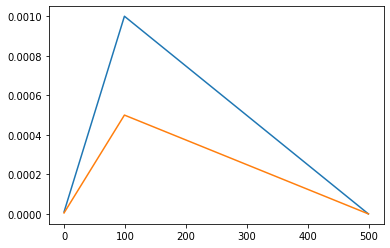

In [16]:
scheduler = "LinearWarmup"
scheduler_params = dict(num_warmup_steps=100, num_training_steps=num_epochs * num_batches)
scheduler = SCHEDULER_REGISTERY.get(scheduler)(optimizer=optimizer, **scheduler_params)

lr1 = []
lr2 = []

for epoch in range(num_epochs):
    for batch in range(num_batches):
        scheduler.step()
        lrs = scheduler.get_lr()
        lr1.append(lrs[0])
        lr2.append(lrs[1])

plt.plot(lr1)
plt.plot(lr2)

### Cosine Warmup Schedule -
> from : https://huggingface.co/transformers/_modules/transformers/optimization.html

In [17]:
# export
@SCHEDULER_REGISTERY.register()
def CosineWarmup(
    optimizer: Optimizer,
    num_warmup_steps: int,
    num_training_steps: int,
    num_cycles: float = 0.5,
    last_epoch: int = -1,
):
    """
    Create a schedule with a learning rate that decreases following the values of the cosine function between the
    initial lr set in the optimizer to 0, after a warmup period during which it increases linearly between 0 and the
    initial lr set in the optimizer.

    Args:
        optimizer (:class:`~torch.optim.Optimizer`):
            The optimizer for which to schedule the learning rate.
        num_warmup_steps (:obj:`int`):
            The number of steps for the warmup phase.
        num_training_steps (:obj:`int`):
            The total number of training steps.
        num_cycles (:obj:`float`, `optional`, defaults to 0.5):
            The number of waves in the cosine schedule (the defaults is to just decrease from the max value to 0
            following a half-cosine).
        last_epoch (:obj:`int`, `optional`, defaults to -1):
            The index of the last epoch when resuming training.

    Return:
        :obj:`torch.optim.lr_scheduler.LambdaLR` with the appropriate schedule.
    """

    def lr_lambda(current_step):
        if current_step < num_warmup_steps:
            return float(current_step) / float(max(1, num_warmup_steps))
        progress = float(current_step - num_warmup_steps) / float(
            max(1, num_training_steps - num_warmup_steps)
        )
        return max(
            0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress))
        )

    return LambdaLR(optimizer, lr_lambda, last_epoch)

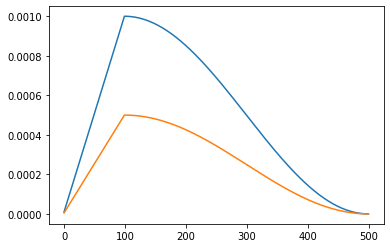

In [18]:
scheduler = "CosineWarmup"
scheduler_params = dict(num_warmup_steps=100, num_training_steps=num_epochs * num_batches)
scheduler = SCHEDULER_REGISTERY.get(scheduler)(optimizer=optimizer, **scheduler_params)

lr1 = []
lr2 = []

for epoch in range(num_epochs):
    for batch in range(num_batches):
        scheduler.step()
        lrs = scheduler.get_lr()
        lr1.append(lrs[0])
        lr2.append(lrs[1])

plt.plot(lr1)
plt.plot(lr2)

### Polynomial Decay with Warmup:¶
> From : https://huggingface.co/transformers/_modules/transformers/optimization.html

In [19]:
# export
@SCHEDULER_REGISTERY.register()
def PolynomialDecayWarmup(
    optimizer,
    num_warmup_steps,
    num_training_steps,
    lr_end=1e-7,
    power=3,
    last_epoch=-1,
):
    """
    Create a schedule with a learning rate that decreases as a polynomial decay from the initial lr set in the
    optimizer to end lr defined by `lr_end`, after a warmup period during which it increases linearly from 0 to the
    initial lr set in the optimizer.

    Args:
        optimizer (:class:`~torch.optim.Optimizer`):
            The optimizer for which to schedule the learning rate.
        num_warmup_steps (:obj:`int`):
            The number of steps for the warmup phase.
        num_training_steps (:obj:`int`):
            The total number of training steps.
        lr_end (:obj:`float`, `optional`, defaults to 1e-7):
            The end LR.
        power (:obj:`float`, `optional`, defaults to 1.0):
            Power factor.
        last_epoch (:obj:`int`, `optional`, defaults to -1):
            The index of the last epoch when resuming training.

    Note: `power` defaults to 1.0 as in the fairseq implementation, which in turn is based on the original BERT
    implementation at
    https://github.com/google-research/bert/blob/f39e881b169b9d53bea03d2d341b31707a6c052b/optimization.py#L37

    Return:
        :obj:`torch.optim.lr_scheduler.LambdaLR` with the appropriate schedule.

    """

    lr_init = optimizer.defaults["lr"]
    assert (
        lr_init > lr_end
    ), f"lr_end ({lr_end}) must be be smaller than initial lr ({lr_init})"

    def lr_lambda(current_step: int):
        if current_step < num_warmup_steps:
            return float(current_step) / float(max(1, num_warmup_steps))
        elif current_step > num_training_steps:
            return lr_end / lr_init  # as LambdaLR multiplies by lr_init
        else:
            lr_range = lr_init - lr_end
            decay_steps = num_training_steps - num_warmup_steps
            pct_remaining = 1 - (current_step - num_warmup_steps) / decay_steps
            decay = lr_range * pct_remaining ** power + lr_end
            return decay / lr_init

    return LambdaLR(optimizer, lr_lambda, last_epoch)

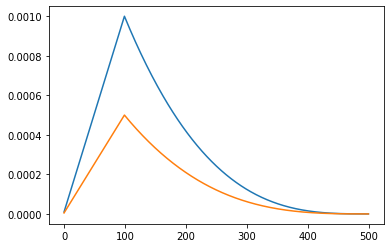

In [20]:
scheduler = "PolynomialDecayWarmup"
scheduler_params = dict(num_warmup_steps=100, num_training_steps=num_epochs * num_batches, power=3)
scheduler = SCHEDULER_REGISTERY.get(scheduler)(optimizer=optimizer, **scheduler_params)

lr1 = []
lr2 = []

for epoch in range(num_epochs):
    for batch in range(num_batches):
        scheduler.step()
        lrs = scheduler.get_lr()
        lr1.append(lrs[0])
        lr2.append(lrs[1])

plt.plot(lr1)
plt.plot(lr2)

## List of Supported Schedulers -

In [21]:
SCHEDULER_REGISTERY

Registry of Schedulers:
╒═════════════════════════════╤════════════════════════════════════════════════════════════════╕
│ Names                       │ Objects                                                        │
╞═════════════════════════════╪════════════════════════════════════════════════════════════════╡
│ CosineAnnealingLR           │ <class 'torch.optim.lr_scheduler.CosineAnnealingLR'>           │
├─────────────────────────────┼────────────────────────────────────────────────────────────────┤
│ CosineAnnealingWarmRestarts │ <class 'torch.optim.lr_scheduler.CosineAnnealingWarmRestarts'> │
├─────────────────────────────┼────────────────────────────────────────────────────────────────┤
│ ReduceLROnPlateau           │ <class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>           │
├─────────────────────────────┼────────────────────────────────────────────────────────────────┤
│ MultiplicativeLR            │ <class 'torch.optim.lr_scheduler.MultiplicativeLR'>            │
├─────

In [22]:
# export
step_schedulers = ["FlatCosScheduler", "OneCycleLR"]

warmup_schedulers = [
    "ConstantWarmup",
    "LinearWarmup",
    "CosineWarmup",
    "PolynomialDecayWarmup",
]

training_steps = ["LinearWarmup", "PolynomialDecayWarmup", "CosineWarmup"]

## Utility Function to load a scheduler from `config` -

In [23]:
# export
def create_scheduler(cfg: DictConfig, optimizer: Optimizer, steps: int, epochs: int):
    "Create a Pytorch-Lightning supported scheduler from cfg. Note: only the `scheduler` config must be passed"
    if cfg.name in step_schedulers:
        cfg.params.steps_per_epoch = steps
        cfg.params.epochs = epochs

    elif cfg.name in warmup_schedulers:
        cfg.params.num_warmup_steps = steps * cfg.params.num_warmup_steps

        # for LinearWarmup & PolynomialDecayWarmup
        if cfg.name in training_steps:
            cfg.params.num_training_steps = steps * epochs

    lr_scheduler = SCHEDULER_REGISTERY.get(cfg.name)(optimizer=optimizer, **cfg.params)

    _logger.info(f"{cfg.name} loaded from SCHEDULER_REGISTERY")

    scheduler = dict(
        scheduler=lr_scheduler,
        monitor=cfg.monitor,
        frequency=cfg.frequency,
        interval=cfg.interval,
    )
    return scheduler

In [24]:
flat_cos = OmegaConf.load("../conf/scheduler/flatcos.yaml")
cosine_warmup = OmegaConf.load("../conf/scheduler/cosine-warmup.yaml")
linear_warmup = OmegaConf.load("../conf/scheduler/linear-warmup.yaml")
constant_warmup = OmegaConf.load("../conf/scheduler/constant-warmup.yaml")
polynomial_warmup = OmegaConf.load("../conf/scheduler/poly-warmup.yaml")

Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers
PolynomialDecayWarmup loaded from SCHEDULER_REGISTERY


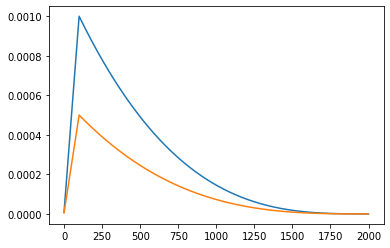

In [25]:
num_epochs = 20
num_batches = 100

optimizer = OPTIM_REGISTERY.get("Ranger")(params=params, **optimizer_params)

#lr_scheduler = create_scheduler(flat_cos, optimizer, num_batches, num_epochs,)
#lr_scheduler = create_scheduler(cosine_warmup, optimizer, num_batches, num_epochs)
#lr_scheduler = create_scheduler(linear_warmup, optimizer, num_batches, num_epochs)
#lr_scheduler = create_scheduler(constant_warmup, optimizer, num_batches, num_epochs)
lr_scheduler = create_scheduler(polynomial_warmup, optimizer, num_batches, num_epochs)

lr1 = []
lr2 = []

for epoch in range(num_epochs):
    for batch in range(num_batches):
        if lr_scheduler["interval"] == "step":
            lr_scheduler["scheduler"].step()
            lrs = lr_scheduler["scheduler"].get_lr()
            lr1.append(lrs[0])
            lr2.append(lrs[1])

        else:
            pass

    if lr_scheduler["interval"] == "epoch":
        lr_scheduler["scheduler"].step()
        lrs = lr_scheduler["scheduler"].get_lr()
        lr1.append(lrs[0])
        lr2.append(lrs[1])
    else:
        pass

plt.plot(lr1)
plt.plot(lr2);

In [26]:
notebook2script()

Converted 00_core.ipynb.
Converted 01_mixmethods.ipynb.
Converted 02_losses.ipynb.
Converted 03_layers.ipynb.
Converted 03a_networks.ipynb.
Converted 04_optimizers.ipynb.
Converted 04a_schedulers.ipynb.
Converted 05_lightning.data.ipynb.
Converted 05a_lightning.core.ipynb.
Converted 05b_lightning.callbacks.ipynb.
Converted 06_fastai.core.ipynb.
Converted index.ipynb.
